# LGBM

In [3]:
!pip install lightgbm

source: Error encountered while sourcing file '/usr/local/opt/nvm/nvm.sh':
source: No such file or directory
     |████████████████████████████████| 1.2 MB 8.8 MB/s 


In [24]:
import lightgbm as lgbm

from functions import *

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import train_test_split


sns.set_theme(style="darkgrid")


In [10]:
flights_test = pd.read_csv('./flights_test.csv')
flights_train = pd.read_csv('./flights_train.csv')

flights_train = flights_train.sort_values(['AIRLINE', 'FLIGHT_NUMBER']).fillna(method='backfill')
flights_test = flights_test.sort_values(['AIRLINE', 'FLIGHT_NUMBER']).fillna(method='backfill')

print(len(flights_test))
print(len(flights_train))

514384
2818553


In [12]:
training_set = preprocessing(flights_train)
test_set = preprocessing(flights_test)

## Feature selection with LGBM

In [13]:
training_set = flights_train.sample(200000)

training_set.columns

features_train = ['MONTH', 'DAY', 'DAY_OF_WEEK',
                  'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'TAXI_OUT', 'WHEELS_OFF',
                  'SCHEDULED_TIME', 'DISTANCE', 'SCHEDULED_ARRIVAL',
                  #  'scheduled_departure_date_time',
                  #  'scheduled_departure_date',
                  'scheduled_departure_timestamp',
                  #  'departure_date_time',
                  'departure_timestamp',
                  'initial_delay']

target_train = 'ARRIVAL_DELAY'

categorical_features = ['AIRLINE', 'FLIGHT_NUMBER',
                        'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']

X_train, X_val, y_train, y_val = train_test_split(
    training_set[features_train], training_set[target_train], test_size=0.2)


In [14]:
train_data = lgbm.Dataset(X_train, label=y_train)#, categorical_feature=categorical_features)

test_data = lgbm.Dataset(X_val, label=y_val)#, categorical_feature=categorical_features)

[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[1]	valid_0's l2: 1612.78
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 1612.33
[3]	valid_0's l2: 1611.86
[4]	valid_0's l2: 1611.43
[5]	valid_0's l2: 1610.66
[6]	valid_0's l2: 1609.94
[7]	valid_0's l2: 1609.84
[8]	valid_0's l2: 1609.22
[9]	valid_0's l2: 1608.57
[10]	valid_0's l2: 1608.43
[11]	valid_0's l2: 1608.29
[12]	valid_0's l2: 1607.69
[13]	valid_0's l2: 1607.5
[14]	valid_0's l2: 1607.22
[15]	valid_0's l2: 1607.08
[16]	valid_0's l2: 1606.54
[17]	vali

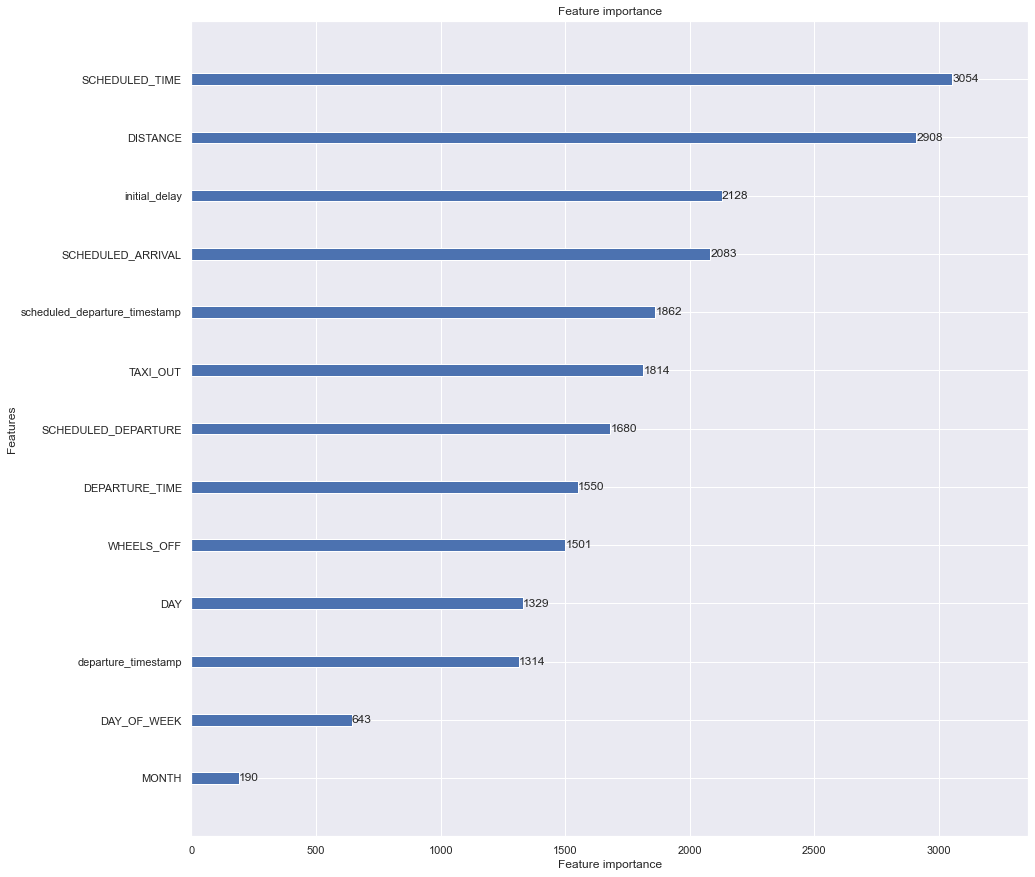

In [15]:
#basic parameter:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'mse',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 25,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

model = lgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=1000,
                       early_stopping_rounds=100)


ax = lgbm.plot_importance(model, max_num_features=40, figsize=(15, 15))
plt.show()


## LGBM Regressor

In [17]:
important_features = ['DISTANCE', 'SCHEDULED_TIME', 'initial_delay',
                      'SCHEDULED_ARRIVAL', 'scheduled_departure_timestamp',
                      'TAXI_OUT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
                      'WHEELS_OFF', 'departure_timestamp', 'DAY']

training_set = flights_train.sample(300000)

X_train, X_val, y_train, y_val = train_test_split(training_set[important_features], training_set['ARRIVAL_DELAY'], test_size=0.2)

In [18]:
reg = lgbm.LGBMRegressor()  # default - 'regression'

reg.fit(X_train, y_train)

LGBMRegressor()

In [30]:
y_pred = reg.predict(X_val[important_features])

predictions = pd.DataFrame({'predicted': y_pred, 'actual': y_val})

In [31]:
mse(predictions['actual'], predictions['predicted'])

105.42718971732947

### Creating Submission

In [28]:
predictions = reg.predict(flights_test[important_features])

submission = pd.DataFrame({'id': flights_test['id'], 'ARRIVAL_DELAY': predictions})
submission.to_csv('submissions/submission_5_LGBM.csv', index=False)

# submission must have 514,384 rows
print(len(submission))

514384
